# Task 1: Build a SURROGATE MODEL using convolutinal LSTM

## Import our own `convlstm` package and other libraries

The installation is shown in `README.md`.

In [3]:
import sys
sys.path.append('..')

In [4]:
from convlstm import ConvLSTMModel, train_model, predict_model, evaluate, set_device, WildfireDatasetImage

import numpy as np
import piq
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error

## Load data

In [2]:
# modify the following paths to the correct paths
train_data_path = './Ferguson_fire_train.npy'
test_data_path = './Ferguson_fire_test.npy'
background_data_path = './Ferguson_fire_background.npy'
obs_data_path = './Ferguson_fire_obs.npy'

In [3]:
img_size = 256
new_img_size = 128 # resize image to 128x128 in order to reduce the computation cost
seq_len = 2 # use 2 frames to predict the next frame

# create dataset. we use the same dataset for validating and testing because we don't really care the mse result of the test set
train_dataset = WildfireDatasetImage(train_data_path, seq_len=seq_len, time_step=10, window_size=1, img_size=new_img_size)
val_dataset = test_dataset = WildfireDatasetImage(test_data_path, seq_len=seq_len, time_step=10, window_size=1, img_size=new_img_size)

## Build and train the model

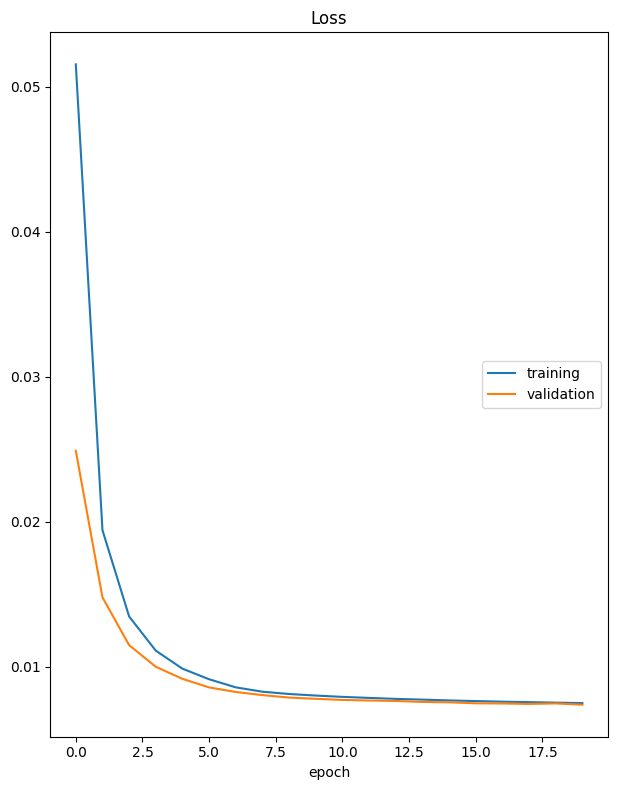

Loss
	training         	 (min:    0.008, max:    0.052, cur:    0.008)
	validation       	 (min:    0.007, max:    0.025, cur:    0.007)


In [4]:
device = set_device()

# define the model
model = ConvLSTMModel(input_channels=1, hidden_channels=16, kernel_size=(3,3), padding=(1,1), activation="relu",
                     frame_size=(new_img_size, new_img_size), num_layers=2).to(device)

checkpoint_path = './checkpoint.pth'
model_path = './convlstm.pth'

# define the optimizer and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 20
batch_size = 4
patience = 10
delta = 1e-4

model = train_model(model, optimizer, criterion, 
                    train_dataset, val_dataset, batch_size, num_epochs, 
                    patience, delta, checkpoint_path)

torch.save(model.state_dict(), model_path)

## Evaluate the model

### Test set

Note: `test_trues` is `new_image_size`*`new_image_size`(here it's 128\*128) because test data is transformed when we use `WildfireDatasetImage`. That results in the low MSE.

In [7]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_trues, test_preds = evaluate(model, test_dataloader)
mean_squared_error(test_trues.flatten(), test_preds.flatten())

0.0026016124

### Background data and observation data

In `predict_model` function it will return original true data instead of transformed data, and predicted data by the trained model.

In [8]:
background_data = np.load(background_data_path)
obs_data = np.load(obs_data_path)

background_dataset = WildfireDatasetImage(background_data_path, time_step=1, img_size=new_img_size)
obs_dataset = WildfireDatasetImage(obs_data_path, time_step=1, img_size=new_img_size)

background_trues, background_preds = predict_model(model, background_data, background_dataset, seq_len=seq_len)
print("background data mse: ", mean_squared_error(background_trues.flatten(), background_preds.flatten()))

obs_trues, obs_preds = predict_model(model, obs_data, obs_dataset, seq_len=seq_len)
print("observed data mse: ", mean_squared_error(obs_trues.flatten(), obs_preds.flatten()))

background data mse:  0.012705498
observed data mse:  0.014195429509172767


In [9]:
bg_ssim = piq.ssim(torch.Tensor(background_trues).view(background_trues.shape[0], 1, background_trues.shape[1], background_trues.shape[2]), background_preds, data_range=1.0)
obs_ssim = piq.ssim(torch.Tensor(obs_trues).view(obs_trues.shape[0], 1, obs_trues.shape[1], obs_trues.shape[2]), obs_preds, data_range=1.0)
print("background data ssim: ", bg_ssim)
print("observed data ssim: ", obs_ssim)

background data ssim:  tensor(0.8662)
observed data ssim:  tensor(0.8830)


### Compare the forecasted results with satellite data and compute the MSE

In [10]:
print("background prediction & observed true data mse: ", mean_squared_error(background_preds.flatten(), obs_trues.flatten()))

background prediction & observed true data mse:  0.08110213626926178


## Save the forecasted results

In [11]:
np.save('./background_preds.npy', background_preds)
np.save('./obs_preds.npy', obs_preds)

## Plot forecasted image and true image

In [12]:
def plot_images(image1, image2, type='background'):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray_r')
    axes[0].set_title(type + ' prediction')
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray_r')
    axes[1].set_title(type + ' true data')
    axes[1].axis('off')

    plt.show()

### Background (the last image)

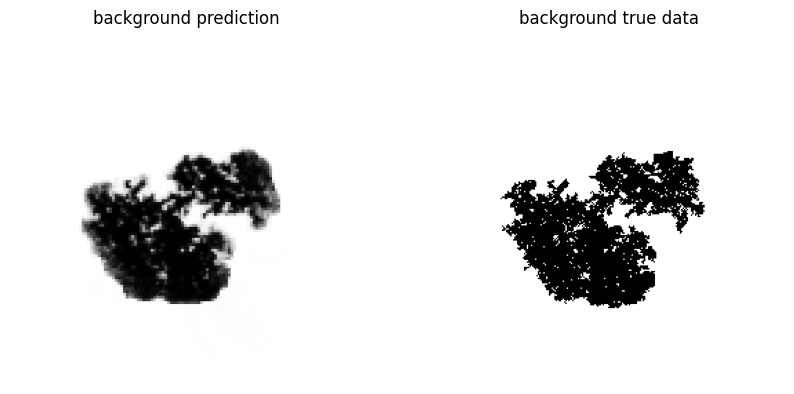

In [13]:
plot_images(background_preds[2].reshape(img_size, img_size), background_trues[2].reshape(img_size, img_size))

### Observed (the last image)

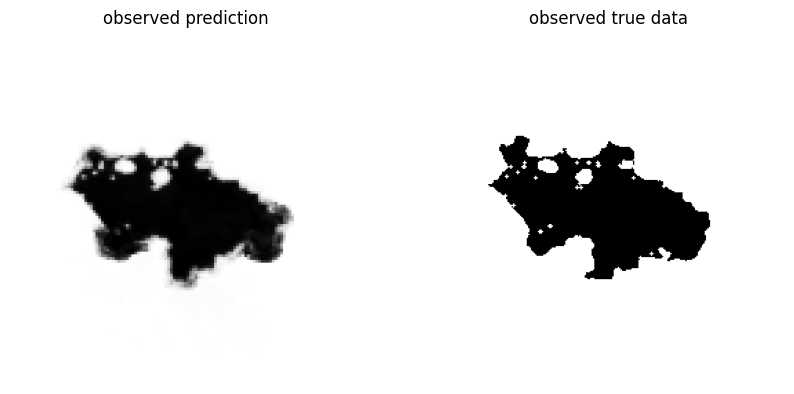

In [14]:
plot_images(obs_preds[2].reshape(img_size, img_size), obs_trues[2].reshape(img_size, img_size), type='observed')